In [28]:
# Classifier imports
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay


import pylab as plt
import pandas as pd
import numpy as np

from joblib import dump, load

# 1. Read data

In [29]:
# Import paths
path_train = "./LISS_example_input_data.csv"
path_outcome = "./LISS_example_groundtruth_data.csv"

In [30]:
# Read data
original_data = pd.read_csv(path_train, encoding="cp1252", low_memory=False)
outcome = pd.read_csv(path_outcome, encoding="cp1252", low_memory=False)

# Drop observations where the outcome is missing
y_isna = outcome['new_child'].isnull()
data = original_data.loc[~y_isna]
outcome = outcome.loc[~y_isna]

# 2. Split data into train and test
First thing always, otherwise you risk overfitting

In [31]:
# Select predictors: education, year of birth, gender, number of children in the household 
# You can do this automatically (not necessarily better): https://scikit-learn.org/stable/modules/feature_selection.html
keepcols = ['oplmet2019', 'gebjaar', 'geslacht', 'aantalki2019']
data = data.loc[:, keepcols]


X_train, X_test, y_train, y_test = train_test_split(data,
                                                    outcome,
                                                    test_size=0.2, random_state=2023)
y_train = y_train["new_child"]
y_test = y_test["new_child"]

# 3. Pre-process and model
You may not want to include the preprocessing in the pipeline if it becomes too cumbersome

Make sure to use the scoring that you want to optimize in the search space

In [32]:
# An example of a preprocessing apart from the pipeline
dict_kids = {'None': 0, 'One child': 1, 'Two children': 2, 'Three children': 3, 'Four children': 4, 'Five children': 5, 'Six children': 6}
X_train["aantalki2019"] = X_train["aantalki2019"].map(dict_kids)

# Create transformers
# Imputer are sometimes not necessary
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=50))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selector(dtype_exclude=object)(X_train)),
        ('cat', categorical_transformer, selector(dtype_include=object)(X_train))])

In [55]:
# Create pipeline
model = Pipeline([
               ("preprocess", preprocessor),
               ("classifier", LogisticRegression(max_iter=500))
               ]) 
                      
# Define the hyperparameters, this can include several classifiers, but will make it slow
# You can see different classifiers here: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
parameters = [
    {
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': np.logspace(-3, 3, 50) #regularization coefficient
    },
    
]

# Perform hyperparameter tuning using cross-validation: https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers
# Scoring metrics: https://scikit-learn.org/stable/modules/model_evaluation.html
# f1 = f1 of the class labeled as 1 (i.e. kids)
grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring="f1", verbose=9) #n_jobs=-1 allows for multiprocessing
grid_search.fit(X_train, y_train)

# Keep best model (or define it from scratch with the best coefficients found)
best_model = grid_search.best_estimator_

best_model


Fitting 5 folds for each of 50 candidates, totalling 250 fits


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gebjaar', 'aantalki2019']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=50))]),
                                                  ['oplmet2019',
                                                   'geslacht'])])),
                ('classifier', LogisticRegression(C=0.001, max_iter=500))])

[CV 1/5] END classifier=LogisticRegression(max_iter=500), classifier__C=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END classifier=LogisticRegression(max_iter=500), classifier__C=754.3120063354608;, score=0.000 total time=   0.0s
[CV 1/5] END classifier=LogisticRegression(max_iter=500), classifier__C=1000.0;, score=0.000 total time=   0.0s
[CV 5/5] END classifier=LogisticRegression(max_iter=500), classifier__C=1000.0;, score=0.000 total time=   0.0s
[CV 3/5] END classifier=LogisticRegression(max_iter=500), classifier__C=0.001;, score=0.000 total time=   0.0s
[CV 1/5] END classifier=LogisticRegression(max_iter=500), classifier__C=79.06043210907701;, score=0.000 total time=   0.0s
[CV 2/5] END classifier=LogisticRegression(max_iter=500), classifier__C=79.06043210907701;, score=0.000 total time=   0.0s
[CV 3/5] END classifier=LogisticRegression(max_iter=500), classifier__C=79.06043210907701;, score=0.000 total time=   0.0s
[CV 4/5] END classifier=LogisticRegression(max_iter=500), clas

[CV 4/5] END classifier=LogisticRegression(max_iter=500), classifier__C=0.001;, score=0.000 total time=   0.0s
[CV 4/5] END classifier=LogisticRegression(max_iter=500), classifier__C=104.81131341546852;, score=0.000 total time=   0.0s
[CV 5/5] END classifier=LogisticRegression(max_iter=500), classifier__C=104.81131341546852;, score=0.000 total time=   0.0s
[CV 1/5] END classifier=LogisticRegression(max_iter=500), classifier__C=138.9495494373136;, score=0.000 total time=   0.0s
[CV 2/5] END classifier=LogisticRegression(max_iter=500), classifier__C=138.9495494373136;, score=0.000 total time=   0.0s
[CV 3/5] END classifier=LogisticRegression(max_iter=500), classifier__C=138.9495494373136;, score=0.000 total time=   0.0s
[CV 4/5] END classifier=LogisticRegression(max_iter=500), classifier__C=138.9495494373136;, score=0.000 total time=   0.0s
[CV 5/5] END classifier=LogisticRegression(max_iter=500), classifier__C=138.9495494373136;, score=0.000 total time=   0.0s
[CV 1/5] END classifier=Lo

In [16]:
#Variable names in the data
best_model["preprocess"].get_feature_names_out()

array(['num__gebjaar', 'num__aantalki2019',
       'cat__oplmet2019_havo/vwo (higher secondary education/preparatory university education, US: senior high school)',
       'cat__oplmet2019_hbo (higher vocational education, US: college)',
       'cat__oplmet2019_mbo (intermediate vocational education, US: junior college)',
       'cat__oplmet2019_vmbo (intermediate secondary education, US: junior high school)',
       'cat__oplmet2019_wo (university)',
       'cat__oplmet2019_infrequent_sklearn', 'cat__geslacht_Female',
       'cat__geslacht_Male'], dtype=object)

# Evaluate the model

Note: The results below are not for LogisticRegression, are for a different model

In [34]:
X_test["aantalki2019"] = X_test["aantalki2019"].map(dict_kids)

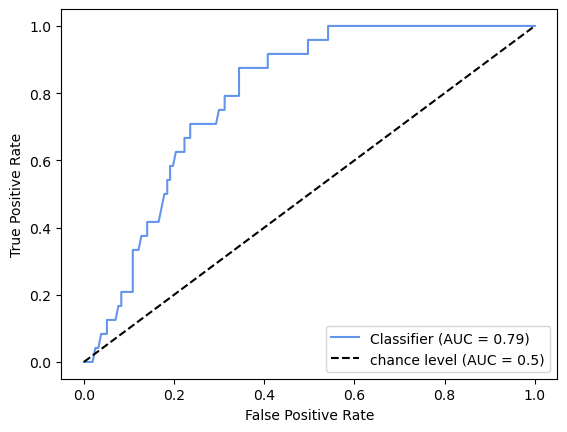

In [35]:
# Print ROC curve, it tells you how well you can balance false and true positives
RocCurveDisplay.from_predictions(
    y_test,
    best_model.predict_proba(X_test)[:, 1],
    color="cornflowerblue",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [36]:
# Create predictions
y_pred = best_model.predict(X_test)

# Report classification table
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       157
         1.0       0.25      0.21      0.23        24

    accuracy                           0.81       181
   macro avg       0.57      0.56      0.56       181
weighted avg       0.80      0.81      0.80       181



# Save models 

In [37]:
import os
os.makedirs("../models", exist_ok=True)

# Dump model (don't change the name)
dump(best_model, "../models/model.joblib")

['../models/model.joblib']

# How the submission would look like, 

In [38]:
def predict_outcomes(df):
    """Process the input data and write the predictions."""
    # Dictionary used
    dict_kids = {'None': 0, 'One child': 1, 'Two children': 2, 'Three children': 3, 'Four children': 4, 'Five children': 5, 'Six children': 6}
    
    # Keep 
    keepcols =  ['oplmet2019', 'gebjaar', 'geslacht', 'aantalki2019']
    results = df[["nomem_encr"]]
    
    df = df.loc[:, keepcols]
    df["aantalki2019"] = df["aantalki2019"].map(dict_kids)
                            
    # Load your trained model from the models directory
    model_path = os.path.join(os.path.dirname(__file__), "..", "models", "model.joblib")
    model = load(model_path)

    # Use your trained model for prediction
    results.loc[:, "prediction"] = model.predict(df)

    #If you use predict_proba to get a probability and a different threshold
    #df["prediction"] = (df["prediction"] >= 0.5).astype(int)
    return results

In [39]:
__file__ = './' #this is not needed outside juypter notebooks
predict_outcomes(original_data)

/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_55392/614848373.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.loc[:, "prediction"] = model.predict(df)


,nomem_encr,prediction
0,800000.0,0.0
1,800018.0,1.0
2,800021.0,0.0
3,800033.0,0.0
4,800042.0,0.0
...,...,...
9454,899917.0,0.0
9455,899935.0,0.0
9456,899942.0,1.0
9457,899957.0,0.0


# Interpretable AI

Note: Again, the result below are not for the LogisticRegression

There are other methods 
    - tree-based models have an argument "best_model.feature_importances_"
    - Other libraries: shap, lime, eli5
    - Other plots, such as partial dependence plots: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

In [54]:
from sklearn.inspection import permutation_importance

def print_sorted_importance(importances, columns, codebook=None):
    for imp, var in sorted(zip(importances, columns))[::-1]:
        if codebook is not None:
            print(f"{imp:2.3f}: {codebook[var]:50.50s}")
        else:
            print(f"{imp:2.3f}: {var:50.50s}")
        
r = permutation_importance(best_model, X_test, y_test,
                            n_repeats=100,
                            random_state=0)

print_sorted_importance(r["importances_mean"], X_test.columns)

0.020: aantalki2019                                      
0.008: gebjaar                                           
0.006: geslacht                                          
-0.003: oplmet2019                                        
